## BaarleNet [Part 2 - Paper Folding]

- Ok does the map/paper folding thing have legs?

In [1]:
import numpy as np
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import torch.optim as optim
import cv2
from matplotlib.gridspec import GridSpec
from tqdm import tqdm
import os

In [2]:
# Set random seed for reproducibility
random_seed=25
torch.manual_seed(random_seed)
np.random.seed(random_seed)

In [3]:
def denorm(p, size=960):
    result = np.zeros_like(p)
    result[..., 0] = (p[..., 0] + 1) * (size / 2)
    result[..., 1] = size - ((p[..., 1] + 1) * (size / 2))
    return result

def viz_map_with_predictions(ax, map, X, y):
    probe=np.zeros((100,100,2))
    for j, xx in enumerate(np.linspace(-1, 1, 100)):
        for k, yy in enumerate(np.linspace(-1, 1, 100)):
            probe[j, k]=[yy,xx]
    probe=probe.reshape(100**2, -1)
    probe_logits=model(torch.tensor(probe).float())
    probe_logits=probe_logits.detach().numpy().reshape(100,100,2)
    probe_softmax = torch.nn.Softmax(dim=1)(torch.tensor(probe_logits.reshape(-1, 2)))
    
    ax.imshow(map.mean(2), cmap='gray')
    ax.imshow(np.flipud(probe_softmax[:,1].reshape(100, 100)), 
               extent=[0, 960, 960, 0],  # This maps to image coordinates
               alpha=0.7,
               cmap='viridis')
    
    X_denorm=denorm(X[:1000,:])
    # plt.scatter(X_denorm[:,0], X_denorm[:,1], c=y[:1000], s=2, alpha=0.8)
    labels=y[:1000]
    y_hat=torch.argmax(model(torch.tensor(X[:1000,:]).float()).detach(),1).numpy()
    tp_mask=np.logical_and(labels==1, y_hat==1)
    fp_mask=np.logical_and(labels==0, y_hat==1)
    fn_mask=np.logical_and(labels==1, y_hat==0)
    tn_mask=np.logical_and(labels==0, y_hat==0)
    ax.scatter(X_denorm[tp_mask,0], X_denorm[tp_mask,1], c='g', s=3, alpha=0.8)
    ax.scatter(X_denorm[fp_mask,0], X_denorm[fp_mask,1], c='r', marker='x', s=5, alpha=0.8)
    ax.scatter(X_denorm[fn_mask,0], X_denorm[fn_mask,1], c='orange', marker='x', s=5, alpha=0.8)
    ax.scatter(X_denorm[tn_mask,0], X_denorm[tn_mask,1], c='purple', marker='o', s=5, alpha=0.8)

In [8]:
map=cv2.imread('Baarle-Nassau_-_Baarle-Hertog-en.svg.png')[:,:,(2,1,0)]

belgium_color=np.array([251,234,81])
netherlands_color=np.array([255, 255, 228])

netherlands_region=((map-netherlands_color)**2).sum(-1)<10
belgium_region=((map-belgium_color)**2).sum(-1)<10000

num_points_to_sample=10000 #10000

b_coords=np.array(np.where(belgium_region)).T.astype('float')
n_coords=np.array(np.where(netherlands_region)).T.astype('float')

#flip and normalize
belgium_coords_all=np.zeros_like(b_coords)
netherlands_coords_all=np.zeros_like(n_coords)

belgium_coords_all[:,0]=b_coords[:,1]/(960) #-1 
belgium_coords_all[:,1]=(960-b_coords[:,0])/(960) #-1
netherlands_coords_all[:,0]=n_coords[:,1]/(960) #-1 
netherlands_coords_all[:,1]=(960-n_coords[:,0])/(960) #-1

## Hmm to balance to classes or do more area proportional? Not sure yet. 
belgium_coords=belgium_coords_all[np.random.choice(len(belgium_coords_all), num_points_to_sample), :]
netherlands_coords=netherlands_coords_all[np.random.choice(len(netherlands_coords_all), num_points_to_sample), :]

X=np.vstack((netherlands_coords, belgium_coords))
y=np.concatenate((np.zeros(len(netherlands_coords)), np.ones(len(belgium_coords)))).astype('int')

rI=np.arange(len(y))
np.random.shuffle(rI)
X=X[rI,:]
y=y[rI]

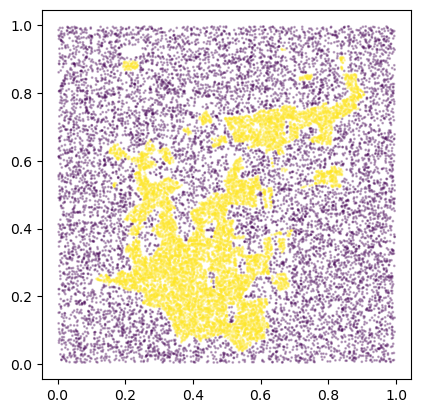

In [9]:
plt.scatter(X[:,0], X[:,1], c=y, s=1, alpha=0.3); plt.axis('square');

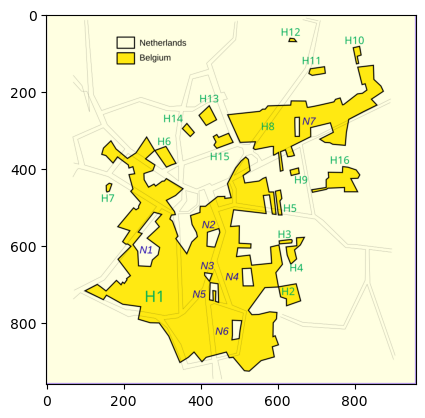

In [10]:
plt.imshow(map)

In [11]:
class BaarleNet(nn.Module):
    def __init__(self, hidden_layers=[64]):
        super(BaarleNet, self).__init__()
        layers = [nn.Linear(2, hidden_layers[0]), nn.ReLU()]
        for i in range(len(hidden_layers)-1):
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_layers[-1], 2))
        self.layers=layers
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [12]:
## With LayerNorm!

# class BaarleNet(nn.Module):
#     def __init__(self, hidden_layers=[64]):
#         super(BaarleNet, self).__init__()
#         layers = [nn.Linear(2, hidden_layers[0]), nn.LayerNorm(hidden_layers[0]), nn.ReLU()]
        
#         for i in range(len(hidden_layers)-1):
#             layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
#             layers.append(nn.LayerNorm(hidden_layers[i+1]))
#             layers.append(nn.ReLU())
        
#         layers.append(nn.Linear(hidden_layers[-1], 2))
#         self.layers = layers
#         self.model = nn.Sequential(*layers)
    
#     def forward(self, x):
#         return self.model(x)

In [13]:
save_dir='may_20_2'
os.makedirs(save_dir, exist_ok=True)

In [14]:
X.shape

(20000, 2)

- BaarleNet([16, 16, 16, 16]), num_epochs = 10000, batch, Accuracy: 0.9546
- BaarleNet([16, 16, 16, 16]), num_epochs = 10000, stochastic, Accuracy: 0.8749
- BaarleNet([64, 64, 64, 64]), num_epochs = 10000, batch, Accuracy: 0.9810 <- starts to get some nice fine structure

In [15]:
# y

In [16]:
torch.manual_seed(random_seed)  

X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Initialize model and optimizer
model = BaarleNet([2])
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.25)
optimizer = optim.Adam(model.parameters(), lr=0.01) #0.005

num_epochs = 10000
for epoch in range(num_epochs):
    # Batch
    outputs = model(X_tensor)
    loss = criterion(outputs, y_tensor)

    #Stochastic
    # outputs = model(torch.tensor(X[epoch%len(y)]).float())
    # loss = criterion(outputs, torch.tensor(y[epoch%len(y)])) 

    #Worth trying minibatch?
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()

    # if epoch==307: break #Stop early here so weights don't get updated before we poke around
    
    optimizer.step()
    if (epoch+1) % (num_epochs//25) == 0:
        outputs_batch = model(X_tensor)
        accuracy=(torch.argmax(outputs_batch, dim=1)==y_tensor).sum().item()/len(y)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')


Epoch [400/10000], Loss: 0.6044, Accuracy: 0.6301
Epoch [800/10000], Loss: 0.5987, Accuracy: 0.6321
Epoch [1200/10000], Loss: 0.5972, Accuracy: 0.6335
Epoch [1600/10000], Loss: 0.5967, Accuracy: 0.6339
Epoch [2000/10000], Loss: 0.5965, Accuracy: 0.6342
Epoch [2400/10000], Loss: 0.5964, Accuracy: 0.6345
Epoch [2800/10000], Loss: 0.5964, Accuracy: 0.6343
Epoch [3200/10000], Loss: 0.5964, Accuracy: 0.6343
Epoch [3600/10000], Loss: 0.5964, Accuracy: 0.6343
Epoch [4000/10000], Loss: 0.5964, Accuracy: 0.6341
Epoch [4400/10000], Loss: 0.5964, Accuracy: 0.6343
Epoch [4800/10000], Loss: 0.5964, Accuracy: 0.6343
Epoch [5200/10000], Loss: 0.5964, Accuracy: 0.6343
Epoch [5600/10000], Loss: 0.5964, Accuracy: 0.6343
Epoch [6000/10000], Loss: 0.5964, Accuracy: 0.6344
Epoch [6400/10000], Loss: 0.5964, Accuracy: 0.6345
Epoch [6800/10000], Loss: 0.5964, Accuracy: 0.6344
Epoch [7200/10000], Loss: 0.5964, Accuracy: 0.6344
Epoch [7600/10000], Loss: 0.5964, Accuracy: 0.6343
Epoch [8000/10000], Loss: 0.5964,

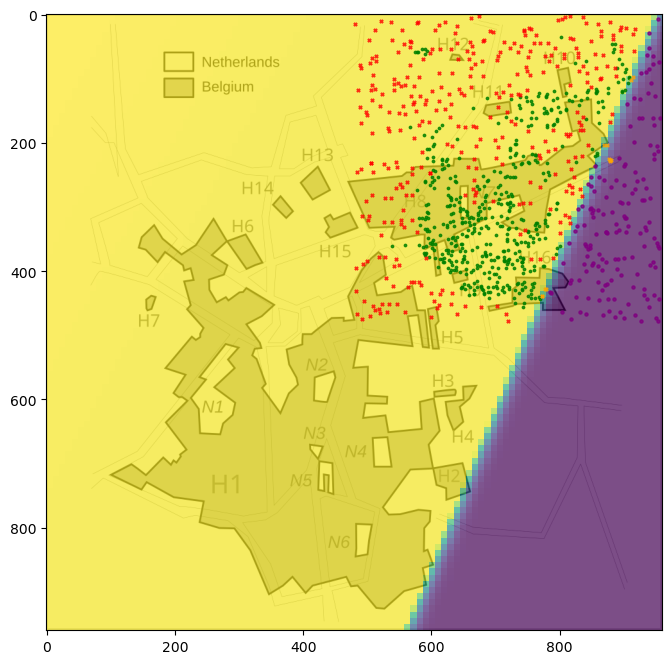

In [17]:
fig=plt.figure(0,(8,8))
ax=fig.add_subplot(111)
viz_map_with_predictions(ax, map, X, y)

In [18]:
model

BaarleNet(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2, out_features=2, bias=True)
  )
)

In [19]:
model.model[0]

Linear(in_features=2, out_features=2, bias=True)

In [20]:
probe=np.zeros((100,100,2))
for j, xx in enumerate(np.linspace(-1, 1, 100)):
    for k, yy in enumerate(np.linspace(-1, 1, 100)):
        probe[j, k]=[yy,xx]
probe=probe.reshape(100**2, -1)

In [21]:
h1=model.model[0](torch.tensor(probe).float())
h1=h1.detach().numpy().reshape(100,100,2)

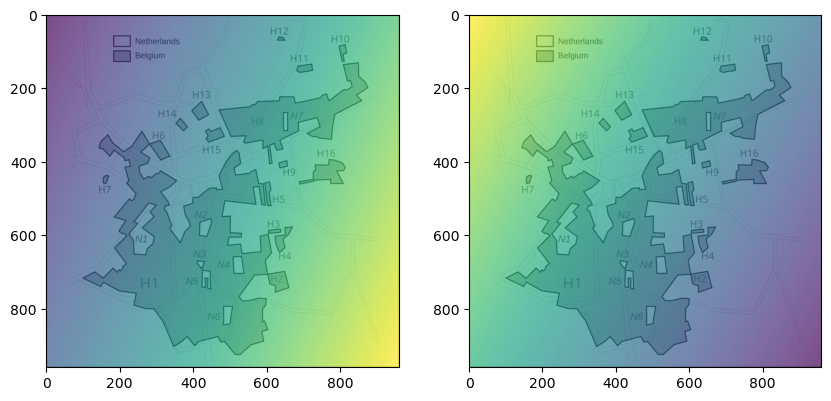

In [22]:
fig=plt.figure(0,(10,5)); 
for i in range(2):
    ax=fig.add_subplot(1,2,i+1)
    ax.imshow(map.mean(2), cmap='gray')
    ax.imshow(np.flipud(h1[:,:,i]), 
               extent=[0, 960, 960, 0],  # This maps to image coordinates
               alpha=0.7,
               cmap='viridis')

In [50]:
h2=model.model[:2](torch.tensor(probe).float())
h2=h2.detach().numpy().reshape(100,100,2)

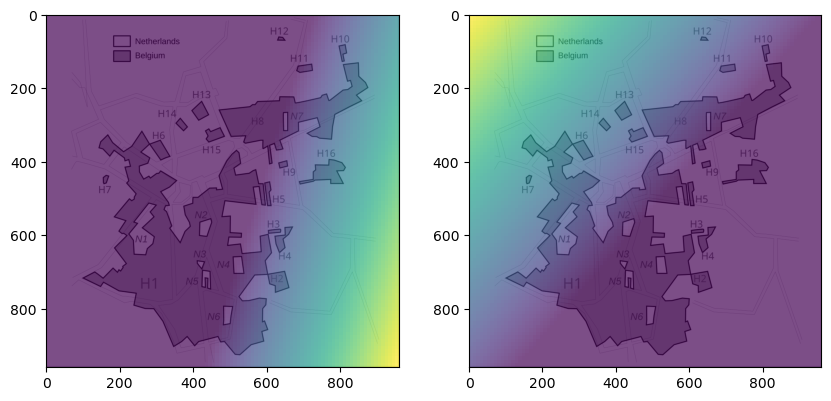

In [54]:
fig=plt.figure(0,(10,5)); 
for i in range(2):
    ax=fig.add_subplot(1,2,i+1)
    ax.imshow(map.mean(2), cmap='gray')
    ax.imshow(np.flipud(h2[:,:,i]), 
               extent=[0, 960, 960, 0],  # This maps to image coordinates
               alpha=0.7,
               cmap='viridis')

- Ok here's where it hurts my head and I can't quite tell if the folding analogy holds up/has legs...
- The hite of each ot these plots becomes the axes to the next plot...ehh that hurts my head -> is that like folding somehow? Kinda seems like no...how to even visualize this...
- Haha can I warp and reshape the map conformal mapping style
- Man could get a little crazy with this video and even do CV tricks on top of shots of paper cutouts
- One thing at a time here though.
- Ok ok ok -> each pixel is going to get assigned a new value, that becomes its new location on a new 2d plot...
- And some points (to the left of the ReLU), get collapsed into lines I think? Is that right?
- I like this idea of actually operating on the pixels in the map -> could add rainbox colors or something later...

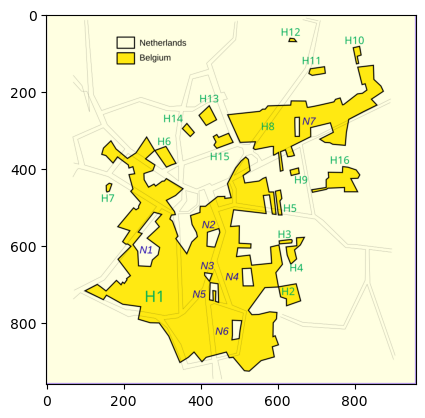

In [23]:
plt.imshow(map)

In [25]:
rgb_pts=[]
for i in range(map.shape[0]):
    for j in range(map.shape[1]):
        rgb_pts.append([i, j, map[i, j, 0], map[i, j, 1], map[i, j, 2]])
rgb_pts=np.array(rgb_pts).astype('float')

tmp=rgb_pts[:,1]/(960) #-1 #Scale to -1 to 1 for now
rgb_pts[:,1]=(960-rgb_pts[:,0])/(960) #-1
rgb_pts[:,0]=tmp

In [26]:
pts_sampled = rgb_pts[np.random.choice(rgb_pts.shape[0], 100000, replace=False)]

In [27]:
rgb_pts.shape, pts_sampled.shape

((921600, 5), (100000, 5))

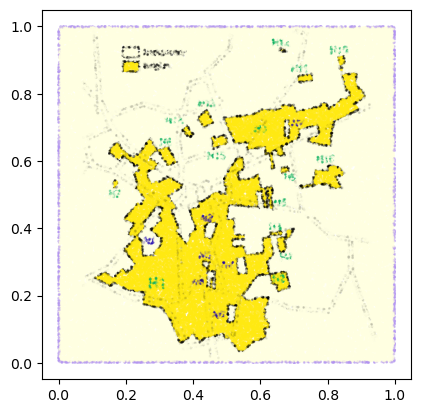

In [28]:
plt.scatter(pts_sampled[:, 0], pts_sampled[:, 1], c=pts_sampled[:,2:]/255., s=1.0, alpha=0.5)
plt.axis('square');

In [29]:
model

BaarleNet(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2, out_features=2, bias=True)
  )
)

In [99]:
with torch.no_grad():
    model.model[0].weight[0,0]=1 #This might be transposed
    model.model[0].weight[0,1]=0
    model.model[0].weight[1,0]=0
    model.model[0].weight[1,1]=1
    model.model[0].bias[0]=0.0
    model.model[0].bias[1]=0.0

In [100]:
model.model[0].weight

Parameter containing:
tensor([[1., 0.],
        [0., 1.]], requires_grad=True)

In [101]:
model.model[0].bias

Parameter containing:
tensor([0., 0.], requires_grad=True)

In [102]:
h1=model.model[0](torch.tensor(pts_sampled[:, :2]).float())
h1=h1.detach().numpy()

In [103]:
h1.shape

(100000, 2)

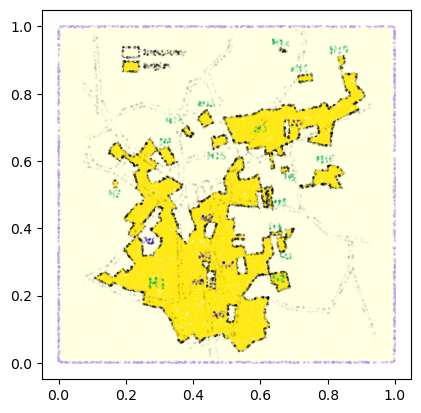

In [104]:
plt.scatter(h1[:, 0], h1[:, 1], c=pts_sampled[:,2:]/255., s=1.0, alpha=0.5)
plt.axis('square');

- Ok ok ok an afine transformation, that makes sense I guess!
- Now with ReLu...

In [105]:
h2=model.model[:2](torch.tensor(pts_sampled[:, :2]).float())
h2=h2.detach().numpy()

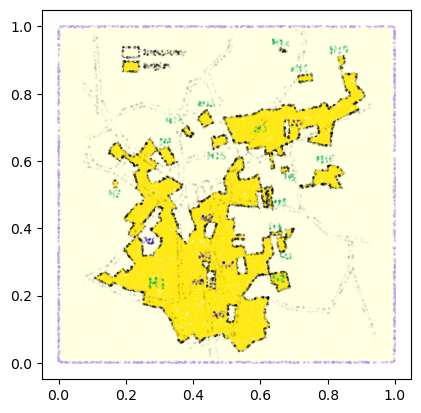

In [106]:
plt.scatter(h2[:, 0], h2[:, 1], c=pts_sampled[:,2:]/255., s=1.0, alpha=0.5)
plt.axis('square');

- Hmm that feels kinda pretty foldy -> I think?!
- Eh not really i think?

In [134]:
l=model(torch.tensor(pts_sampled[:, :2]).float())
l=l.detach().numpy()

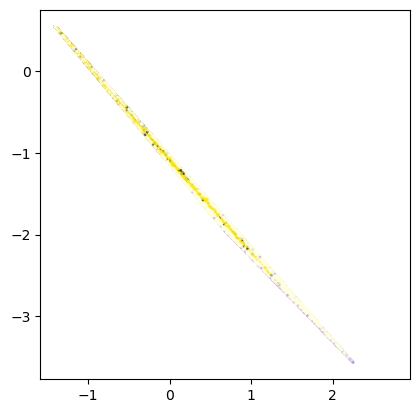

In [135]:
plt.scatter(l[:, 0], l[:, 1], c=pts_sampled[:,2:]/255., s=1.0, alpha=0.5)
plt.axis('square');

- Hmm not quite looking like folding paper lol.
- These geometries get exxagerated during training, so there's probably a more mild version that achieves a similiar effect.

In [ ]:
probe_logits=model(torch.tensor(probe).float())
probe_logits=probe_logits.detach().numpy().reshape(100,100,2)

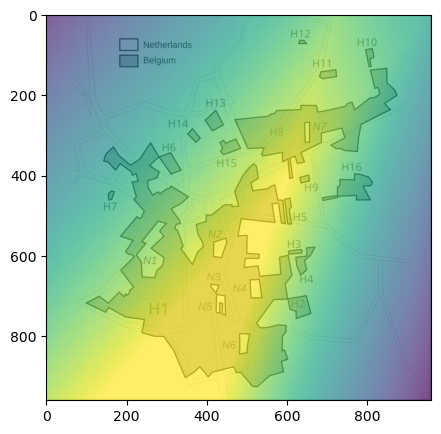

In [35]:
fig=plt.figure(0,(5,5))
ax=fig.add_subplot(111)
ax.imshow(map.mean(2), cmap='gray')
ax.imshow(np.flipud(probe_logits[:,:,1]), 
           extent=[0, 960, 960, 0],  # This maps to image coordinates
           alpha=0.7,
           cmap='viridis')

Hmm cool that it's actually a natural XOR...

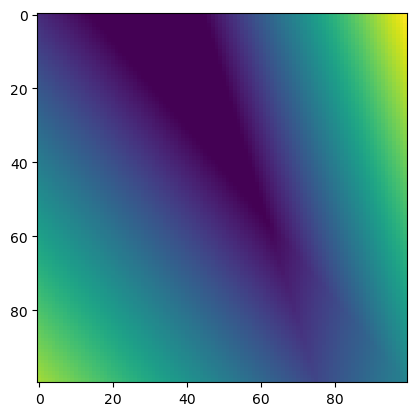

In [31]:
plt.imshow(probe_logits[:,:,0])

In [ ]:



probe_softmax = torch.nn.Softmax(dim=1)(torch.tensor(probe_logits.reshape(-1, 2)))